In [2]:
import pandas as pd
import numpy as np
import itertools

# 2. 시각화
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# 3. 유틸
# tqdm 패키지는 반복문에 대해 얼마나 진척되었는지를 가시적으로 확인할 수 있도록 도와줍니다.
# https://github.com/tqdm/tqdm 사용법은 정말 간단합니다.
from tqdm.auto import tqdm


# 4. 설정
# 경고가 나와서, 출력이 많아지지 않기 위해 ignore를 설정해주었습니다.
import warnings
warnings.filterwarnings('ignore')


# 5. stats models
# 시계열 모델을 위한 ARIMA를 임포트 해주었습니다.
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [7]:
train_x = pd.read_csv("train_x_df.csv")
train_y = pd.read_csv("train_y_df.csv")
test_x = pd.read_csv("test_x_df.csv")

In [3]:
def make_mfi(my_df):
    period = 14
    result = []

    for sample_id in my_df['sample_id'].unique().tolist():
      df = my_df[my_df['sample_id'] == sample_id]

      df['typical_price'] = (df['close'] + df['high'] + df['low']) / 3
      df['money_flow'] = df['typical_price'] * df['volume']
      df['price_diff'] = df.groupby(['sample_id'])['typical_price'].diff(1).shift(-1)
      df['pf'] = np.where(df['price_diff'] > 0, df['money_flow'], 0)
      df['nf'] = np.where(df['price_diff'] < 0, df['money_flow'], 0)

      # 상승분의 14일 평균을 구해줍니다.
      # 하락분의 14일 평균을 구해줍니다.
      df["pmf"] = df["pf"].rolling(window=period, min_periods=period).sum()
      df["nmf"] = df["nf"].rolling(window=period, min_periods=period).sum()

      MFI = df['pmf'] / (df['pmf'] + df['nmf'])
      df['mfi'] = MFI
      df['mfi'] = df['mfi'].shift(1)

      result.append(df)
      
    output = pd.concat(result, axis=0)

    return output

In [8]:
train_x = make_mfi(train_x[train_x['sample_id'] < 50])
test_x = make_mfi(test_x)

In [6]:
# train_x
test_x

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av,typical_price,money_flow,price_diff,pf,nf,pmf,nmf,mfi
0,7929,0,1,0.941549,0.941773,0.940431,0.941176,0.169500,85.595390,0.089465,0.108427,54.745537,0.941127,0.159521,-0.000155,0.00000,0.159521,NaN,NaN,NaN
1,7929,1,1,0.941586,0.941736,0.940282,0.940897,0.237560,119.955322,0.119287,0.105256,53.145061,0.940971,0.223538,-0.000485,0.00000,0.223538,NaN,NaN,NaN
2,7929,2,1,0.941270,0.941586,0.938940,0.940934,0.231588,116.848953,0.149109,0.163196,82.363953,0.940487,0.217805,-0.000242,0.00000,0.217805,NaN,NaN,NaN
3,7929,3,1,0.940971,0.941363,0.939052,0.940319,0.238199,120.162766,0.201297,0.157981,79.687485,0.940244,0.223965,-0.000168,0.00000,0.223965,NaN,NaN,NaN
4,7929,4,1,0.940077,0.940561,0.939760,0.939909,0.082302,41.511501,0.055916,0.009733,4.908966,0.940077,0.077370,0.000801,0.07737,0.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048795,8688,1375,5,1.005905,1.007405,1.005392,1.006122,32184.292969,23957.617188,66.215317,4388.184082,3269.062256,1.006306,32387.253916,-0.001239,0.00000,32387.253916,815101.896991,441397.594525,0.649240
1048796,8688,1376,5,1.006243,1.006554,1.004040,1.004608,46183.425781,34342.394531,93.241982,8526.371094,6343.348145,1.005067,46417.456964,-0.001396,0.00000,46417.456964,815101.896991,380956.938350,0.648708
1048797,8688,1377,5,1.004608,1.005284,1.002865,1.002865,55310.468750,41101.046875,97.295982,16837.339844,12520.099609,1.003671,55513.516250,-0.002680,0.00000,55513.516250,815101.896991,297428.568114,0.681490
1048798,8688,1378,5,1.002865,1.002905,1.000013,1.000054,114685.742188,85007.203125,127.025307,35383.035156,26229.859375,1.000991,114799.389690,-0.002676,0.00000,114799.389690,702086.136427,412227.957804,0.732656


In [9]:
TRAIN_SAMPLE_ID_LIST = train_x["sample_id"].unique().tolist()
TEST_SAMPLE_ID_LIST = test_x["sample_id"].unique().tolist()

In [10]:
def get_typical_price(df,sample_id):    
    return df[df["sample_id"] == sample_id]['typical_price'].values

In [11]:
def get_mfi(df,sample_id):
  return df[df["sample_id"] == sample_id]['mfi'].values

In [15]:
# ARIMA의 (p,d,q) 값이 (4,0,1)에서 수렴하지 않을 경우
# (1,1,0)로 변경하여 다시 학습 및 추론
result = np.zeros([50,120])
def model_fit(df, sample_id_list):
  for sample_id in tqdm(sample_id_list):
    price_x = get_typical_price(df, sample_id)
    # mfi_series = get_mfi(df, sample_id)
    
    # 2. ARIMA
    # 1) 모델 정의
    ARIMA_MODEL = {}
    ARIMA_MODEL_FIT = {}

    # 2) AR 모델 적용
    try:
        ARIMA_MODEL = ARIMA(price_x, order = (4,1,0))
        ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

    # 3) 수렴하지 않을 경우 p d q 를 1, 1, 0으로 사용
    except:
        ARIMA_MODEL = ARIMA(price_x, order = (1, 1, 0))
        ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

    # 4) ARIMA 예측
    ARIMA_FORECAST  = ARIMA_MODEL_FIT.predict(1,120, typ='levels')
    result[sample_id,:] = ARIMA_FORECAST

  return result

In [16]:
result = model_fit(train_x, TRAIN_SAMPLE_ID_LIST)
# result = model_fit(test_x, TEST_SAMPLE_ID_LIST)

  4%|▍         | 2/50 [00:00<00:02, 18.35it/s]asef
***********
***********
***********
 12%|█▏        | 6/50 [00:00<00:02, 17.96it/s]***********
***********
***********
***********
 20%|██        | 10/50 [00:00<00:02, 17.30it/s]***********
***********
***********
***********
 28%|██▊       | 14/50 [00:00<00:01, 18.21it/s]***********
***********
***********
***********
 36%|███▌      | 18/50 [00:01<00:01, 17.74it/s]***********
***********
***********
***********
 44%|████▍     | 22/50 [00:01<00:01, 17.32it/s]***********
***********
***********
***********
 52%|█████▏    | 26/50 [00:01<00:01, 17.61it/s]***********
***********
***********
***********
 60%|██████    | 30/50 [00:01<00:01, 15.70it/s]***********
***********
***********
 68%|██████▊   | 34/50 [00:03<00:04,  3.75it/s]***********
***********
***********
***********
 76%|███████▌  | 38/50 [00:04<00:01,  6.21it/s]***********
***********
***********
***********
 80%|████████  | 40/50 [00:04<00:01,  7.70it/s]***********
***********


In [27]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    # plt.axhline(1, c = 'red')
    plt.legend()

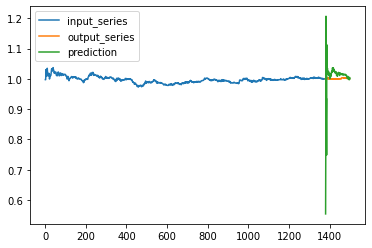

In [44]:
idx = 30

x_series = train_x[train_x['sample_id'] == 30]['open'].reset_index()
x_series = x_series['open'][1:]
y_series = train_y[train_y['sample_id'] == 30]['open']


plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), result[30], label = 'prediction')
plt.legend()
plt.show()

In [41]:
x_series

0       0.554023
1       0.997241
2       0.997241
3       1.008321
4       1.030471
          ...   
1375    0.999679
1376    0.999679
1377    0.998637
1378    0.998659
1379    1.000000
Name: open, Length: 1380, dtype: float64

In [10]:
# ARIMA의 (p,d,q) 값이 (4,0,1)에서 수렴하지 않을 경우
# (1,1,0)로 변경하여 다시 학습 및 추론
# result = np.zeros([300,120])
def model_fit(df, sample_id_list):
  result = []
  for sample_id in tqdm(sample_id_list):
    price_x = get_typical_price(df, sample_id)
    mfi_series = get_mfi(df, sample_id)

    auto_arima_model = auto_arima(price_x, start_p=0, start_q=0, max_p=5, max_q=5, seasonal=False, 
                              d=1,
                              trace=True,
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=False)
    
    # 2. ARIMA
    # 1) 모델 정의
    ARIMA_MODEL = {}
    ARIMA_MODEL_FIT = {}

    # 2) AR 모델 적용
    try:
        ARIMA_MODEL = ARIMA(price_x, order = auto_arima_model.to_dict()['order'])
        ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

    # 3) 수렴하지 않을 경우 p d q 를 1, 1, 0으로 사용
    except:
        ARIMA_MODEL = ARIMA(price_x, order = (1, 1, 0))
        ARIMA_MODEL_FIT = ARIMA_MODEL.fit(trend = 'nc', full_output = True, disp = True)

    # 4) ARIMA 예측
    ARIMA_FORECAST  = ARIMA_MODEL_FIT.predict(1,120, typ='levels')

    # 3. 데이처 처리
    # 1) 최대 부분인 인덱스를 찾는데 해당 시점에 매도를 진행합니다.
    sell_time = np.argmax(ARIMA_FORECAST)

    # 2) 최대값을 찾습니다.
    max_val = np.max(ARIMA_FORECAST)
    
    mfi_last_val = mfi_series[1379]

    # 4. 투자 전략
    buy_quantity = 0

    # 1) typical_price가 1.15 이상이면 투자합니다.
    if  max_val > 1.15:
        buy_quantity = 1

    if mfi_last_val > 0.7:
        buy_quantity = 0
        
    # 3) 만약 mfi의 값이 65 보다 크면, 초과매수 상태로 판단하여 투자하지 않습니다.
    if mfi_last_val < 0.3:
        buy_quantity = 1

    # 5. 결과
    result_list = [
                    sample_id,
                    buy_quantity,
                    sell_time
                  ]

    result.append(result_list)
  return result

In [11]:
# result = model_fit(train_x, TRAIN_SAMPLE_ID_LIST)
result = model_fit(test_x, TEST_SAMPLE_ID_LIST)

 intercept   : AIC=-14595.984, Time=0.75 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-14594.764, Time=1.02 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=-14596.926, Time=1.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14578.977, Time=0.26 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14597.401, Time=0.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14596.118, Time=0.48 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-14488.075, Time=1.00 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-14590.774, Time=0.40 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14594.703, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-14595.414, Time=0.87 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14488.074, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-14486.074, Time=0.99 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-14596.534, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-14594.826, Time=0.59 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-14486.074, Time=0.89 sec
 AR

In [12]:
submit_columns = [
                  "sample_id", 
                  "buy_quantity", 
                  "sell_time"
                  ]

submit = pd.DataFrame(data=result, columns=submit_columns)

In [13]:
submit

,sample_id,buy_quantity,sell_time
0,7929,0,116
1,7930,0,47
2,7931,0,32
3,7932,0,21
4,7933,0,2
...,...,...,...
755,8684,0,5
756,8685,1,55
757,8686,0,23
758,8687,0,0


In [14]:
submit[submit["buy_quantity"] == 1].shape[0]  

109

In [15]:
submit.buy_quantity.value_counts()

0    651
1    109
Name: buy_quantity, dtype: int64

In [16]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)

    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [17]:
train_y = train_y[train_y['sample_id'] < 50]

NameError: name 'train_y' is not defined

In [50]:
total_momey, total_momey_list = COIN(train_y,
                                     submit)

In [51]:
print(total_momey)
print(total_momey_list)

10020.847077868026
[10092.11634282645, 10092.11634282645, 10092.11634282645, 10092.11634282645, 10092.11634282645, 10092.11634282645, 10089.02524577841, 10089.02524577841, 10091.797852589892, 10091.797852589892, 10091.797852589892, 10091.797852589892, 10250.533136582384, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10089.692593550026, 10079.605423379626, 10079.605423379626, 10079.605423379626, 10096.765397020912, 10096.765397020912, 10223.423277233, 10223.423277233, 10223.423277233, 10223.423277233, 10213.202409811587, 10213.202409811587, 10213.202409811587, 10213.202409811587, 10213.202409811587, 10213.202409811587, 10213.202409811587, 10020.847077868026, 10020.847077868026, 10020.847077868026]


In [18]:
FILE_NAME = "/0617_AUTO_ARIMA_MFI_30UNDER_MAXVAL_115_SUBMIT.csv"

In [19]:
SUBMIT_PATH = "./data"
RESULT_PATH = SUBMIT_PATH + FILE_NAME

submit.to_csv(RESULT_PATH, index=False)